# Telco: Analysis of Churn

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz

import acquire as a
import prepare as p
import explore as e
import model as m

import os
from env import host, user, password

## Plan

### Objectives
- Create README.md file detailing
    - DS pipeline process
    - instructions on how to repeat pipeline process
    - initial hypotheses and conclusions
    - key findings, recommendations, and takeaways
- Create Jupyter Notebook documenting and commenting necessary
    - code
    - reasoning
    - findings
    - takeaways
- Create modules that hold useful functions
- Create CSV file with customer_id, probability of churn, and prediction of churn (1=churn, 0=not_churn).
- Present final notebook to Codeup Data Science team
- Answer questions stoically 

### Goals
- Identify key drivers of customer churn from Telco
- Create ML models to predict customer churn
- Document process

### Executive Summary

- I found that the main drivers of churn were price,
    - On average, customers that churned paid a higher monthly fees than the retained counterparts
    - Customers were willing to pay more for tech support
    - Customers who had fiber optic internet paid more, and churned at a higher rate than other internet types
    - Tenure alone is not a good indicator for churn
- I used three different models and all performed better than my baseline
    - I chose my Logistic Regression Model as my MVP
___

## Acquire

In [2]:
# acquire data from SQL database
df = a.get_telco_data()
df.head()

customer_id  gender  senior_citizen partner dependents  tenure  \
0  0016-QLJIS  Female               0     Yes        Yes      65   
1  0017-DINOC    Male               0      No         No      54   
2  0019-GFNTW  Female               0      No         No      56   
3  0056-EPFBG    Male               0     Yes        Yes      20   
4  0078-XZMHT    Male               0     Yes         No      72   

  phone_service    multiple_lines online_security device_protection  \
0           Yes               Yes             Yes               Yes   
1            No  No phone service             Yes                No   
2            No  No phone service             Yes               Yes   
3            No  No phone service             Yes               Yes   
4           Yes               Yes              No               Yes   

  tech_support streaming_tv streaming_movies paperless_billing  \
0          Yes          Yes              Yes               Yes   
1          Yes          Yes               No                No   
2          Yes           No               No                No   
3          Yes           No               No               Yes   
4          Yes          Yes              Yes               Yes   

   monthly_charges total_charges churn contract_type internet_service_type  \
0            90.45        5957.9    No      Two year                   DSL   
1            45.20       2460.55    No      Two year                   DSL   
2            45.05        2560.1    No      Two year                   DSL   
3            39.40         825.4    No      Two year                   DSL   
4            85.15        6316.2    No      Two year                   DSL   

                payment_type  
0               Mailed check  
1    Credit card (automatic)  
2  Bank transfer (automatic)  
3    Credit card (automatic)  
4  Bank transfer (automatic)

In [3]:
a.gen_view(df)

------------------------------
General overview of dataframe.
------------------------------

Descriptive stats:

       senior_citizen       tenure  monthly_charges
count     7043.000000  7043.000000      7043.000000
mean         0.162147    32.371149        64.761692
std          0.368612    24.559481        30.090047
min          0.000000     0.000000        18.250000
25%          0.000000     9.000000        35.500000
50%          0.000000    29.000000        70.350000
75%          0.000000    55.000000        89.850000
max          1.000000    72.000000       118.750000


Column and row info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                

In [4]:
# separate variables into target, categorical, and quantitative for easier exploration and viz

target = 'churn'

quant_vars = ['monthly_charges', 'tenure', 'total_charges']

cat_vars = list(df.columns[~df.columns.isin(['monthly_charges', 'tenure', 'total_charges', 'customer_id','churn'])])

In [5]:
def plot_dist(quant_vars, cat_vars):
    '''
    Function loops through all columns and plot each distribution.
    '''
    for col in df.columns[1:]:
        plt.title(f'Histogram for {col}')
        sns.histplot(x=df[col], hue=df.churn, bins=10)
        plt.tight_layout()
        plt.show()

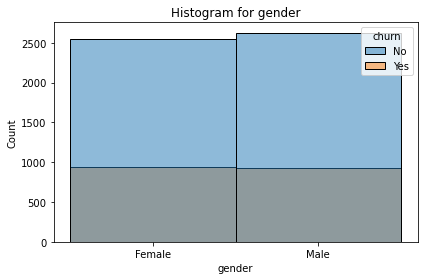

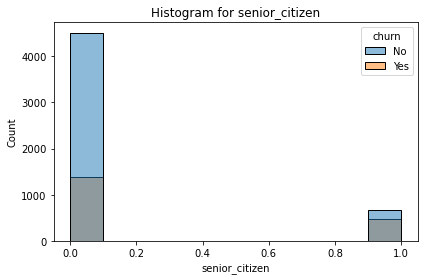

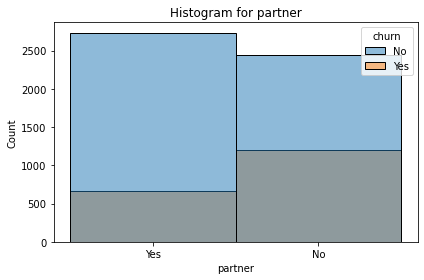

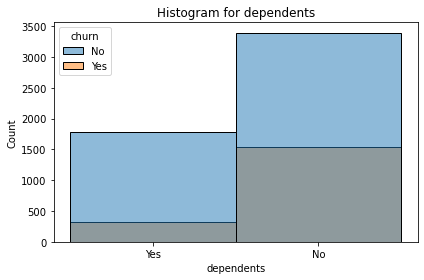

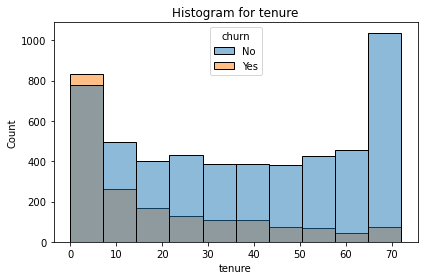

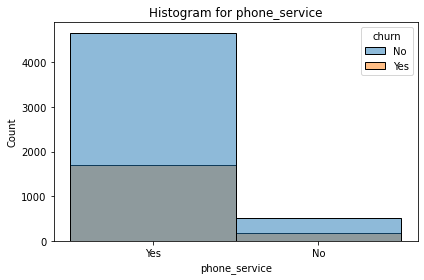

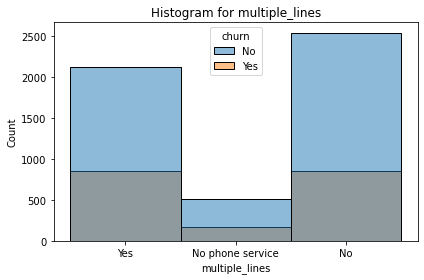

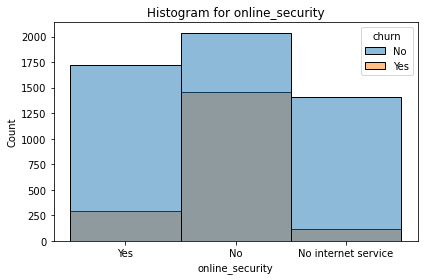

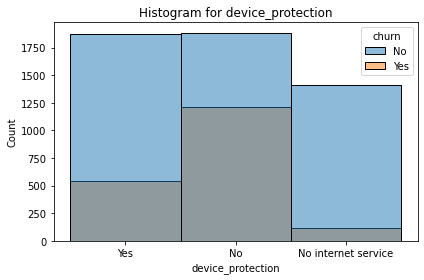

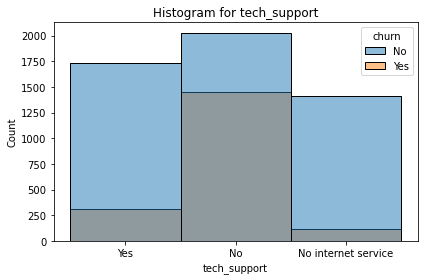

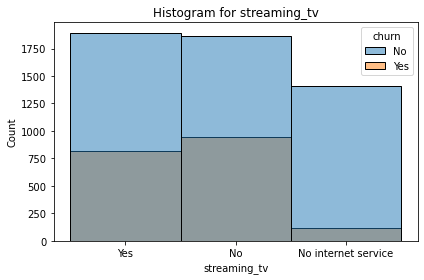

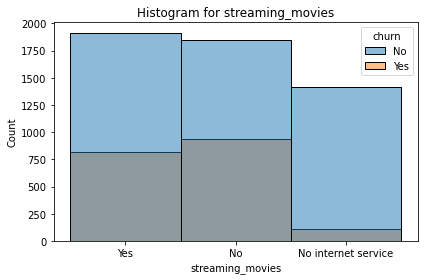

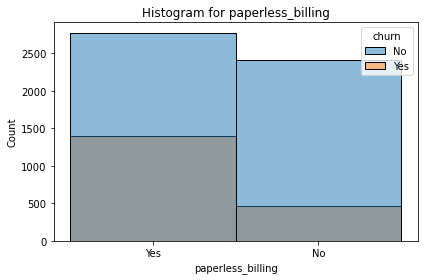

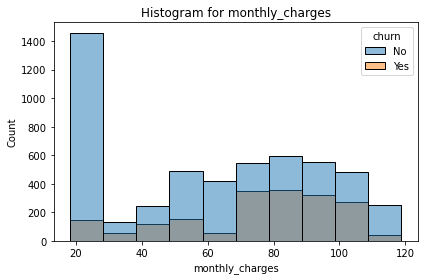

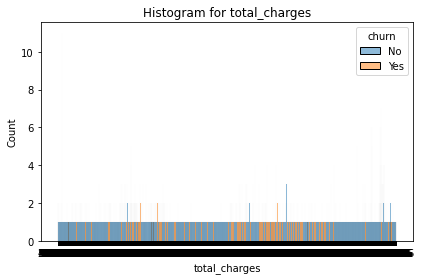

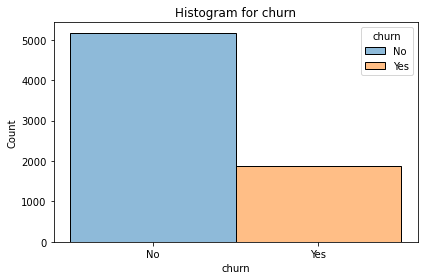

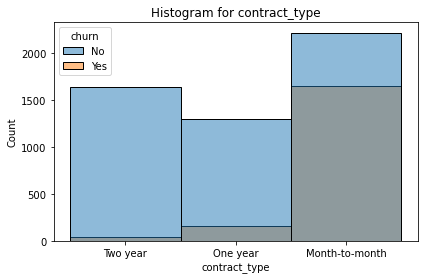

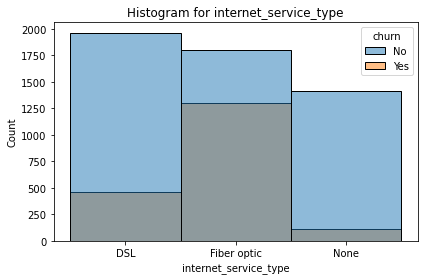

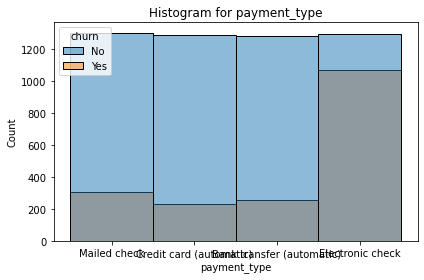

In [6]:
plot_dist(quant_vars, cat_vars)

**Acquire: Key Findings & Takeaways**
- using the acquire.py module, I acquired the dataframe from the SQL teclo_churn database and converted it to a csv file
- total_charges column has empty values that will ne to be dealt with
- categorical columns with more than two outcomes will need dummy variables
- customer_id has no use and will need to be dropped
- from the histogram, I can see that tenure and monthly_charges have bimodal distributions
    - total_charges distribution will need to be explored later

---

## Prepare

From gen_view(), we see that total_charges has blank_spaces for values.

In [7]:
df[df.total_charges == ' ']

customer_id  gender  senior_citizen partner dependents  tenure  \
85    1371-DWPAZ  Female               0     Yes        Yes       0   
156   2775-SEFEE    Male               0      No        Yes       0   
236   4075-WKNIU  Female               0     Yes        Yes       0   
255   4472-LVYGI  Female               0     Yes        Yes       0   
339   5709-LVOEQ  Female               0     Yes        Yes       0   
5681  2520-SGTTA  Female               0     Yes        Yes       0   
5717  3115-CZMZD    Male               0      No        Yes       0   
5727  3213-VVOLG    Male               0     Yes        Yes       0   
5798  4367-NUYAO    Male               0     Yes        Yes       0   
6007  7644-OMVMY    Male               0     Yes        Yes       0   
6257  2923-ARZLG    Male               0     Yes        Yes       0   

     phone_service    multiple_lines      online_security  \
85              No  No phone service                  Yes   
156            Yes               Yes                  Yes   
236            Yes               Yes                   No   
255             No  No phone service                  Yes   
339            Yes                No                  Yes   
5681           Yes                No  No internet service   
5717           Yes                No  No internet service   
5727           Yes               Yes  No internet service   
5798           Yes               Yes  No internet service   
6007           Yes                No  No internet service   
6257           Yes                No  No internet service   

        device_protection         tech_support         streaming_tv  \
85                    Yes                  Yes                  Yes   
156                    No                  Yes                   No   
236                   Yes                  Yes                  Yes   
255                   Yes                  Yes                  Yes   
339                   Yes                   No                  Yes   
5681  No internet service  No internet service  No internet service   
5717  No internet service  No internet service  No internet service   
5727  No internet service  No internet service  No internet service   
5798  No internet service  No internet service  No internet service   
6007  No internet service  No internet service  No internet service   
6257  No internet service  No internet service  No internet service   

         streaming_movies paperless_billing  monthly_charges total_charges  \
85                     No                No            56.05                 
156                    No               Yes            61.90                 
236                    No                No            73.35                 
255                    No               Yes            52.55                 
339                   Yes                No            80.85                 
5681  No internet service                No            20.00                 
5717  No internet service                No            20.25                 
5727  No internet service                No            25.35                 
5798  No internet service                No            25.75                 
6007  No internet service                No            19.85                 
6257  No internet service               Yes            19.70                 

     churn contract_type internet_service_type               payment_type  
85      No      Two year                   DSL    Credit card (automatic)  
156     No      Two year                   DSL  Bank transfer (automatic)  
236     No      Two year                   DSL               Mailed check  
255     No      Two year                   DSL  Bank transfer (automatic)  
339     No      Two year                   DSL               Mailed check  
5681    No      Two year                  None               Mailed check  
5717    No      Two year                  None               Mailed check  
5727    No      Two y

In [8]:
x = df[df.total_charges==' '].index.values.tolist()
x

[85, 156, 236, 255, 339, 5681, 5717, 5727, 5798, 6007, 6257]

In [9]:
df[['monthly_charges','tenure','total_charges','churn']][df.tenure == 1].sample(11)

monthly_charges  tenure total_charges churn
1410            50.15       1         50.15    No
7041            18.90       1          18.9    No
2310            50.35       1         50.35   Yes
4807            73.55       1         73.55   Yes
6648            19.90       1          19.9    No
5122            71.35       1         71.35   Yes
1669            45.10       1          45.1   Yes
4664            69.40       1          69.4   Yes
4731            71.55       1         71.55   Yes
2298            49.55       1         49.55    No
1671            50.90       1          50.9   Yes

In [10]:
df = p.prep_data(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   senior_citizen                        7032 non-null   int64  
 1   partner                               7032 non-null   int64  
 2   dependents                            7032 non-null   int64  
 3   tenure                                7032 non-null   int64  
 4   phone_service                         7032 non-null   int64  
 5   multiple_lines                        7032 non-null   int64  
 6   online_security                       7032 non-null   int64  
 7   device_protection                     7032 non-null   int64  
 8   tech_support                          7032 non-null   int64  
 9   streaming_tv                          7032 non-null   int64  
 10  streaming_movies                      7032 non-null   int64  
 11  paperless_billing

In [12]:
train, validate, test = p.train_validate_test_split(df, target, seed=123)

In [13]:
train.shape

(3937, 25)

In [14]:
validate.shape

(1688, 25)

In [15]:
test.shape

(1407, 25)

**Prepare: Key Findings & Takeaways**
- Certain customers have no total charge because they have not yet been charged for a service
- Since there are only 11 of these customers, I will drop these customers from the df to avoid affecting the results
- Dummy variable were made for 'internet_service_type', 'contract_type', 'gender', and 'payment_type'
    - Only gender', and 'payment_type' had their first new dummy vars dropped
- Columns with 'Yes' or 'No' outcomes were converted to 0
    - In some cases, so columns had another column that equated to not having the service
    - This option was converted to 0
- dataframe was converted to train (3937, 24), validate (1688, 24), and test (1407, 24) samples
- new column 'tenure_years' was added as float dtype

## Explore

In [16]:
# create new vars for target, categorical, and quantitative with new data

target = 'churn'

quant_vars = ['monthly_charges','tenure', 'tenure_years', 'total_charges']


cat_vars = list(df.columns[~df.columns.isin(['monthly_charges','tenure', 'tenure_years', 'total_charges', 'churn'])])

senior_citizen 
_____________________

         chi2       p-value  degrees of freedom
0  109.763476  1.104091e-25                   1

observed:
 churn              0     1   All
senior_citizen                  
0               2524   766  3290
1                367   280   647
All             2891  1046  3937

expected:
              0           1
0  2415.897892  874.102108
1   475.102108  171.897892


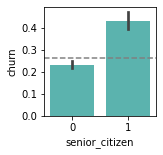


_____________________

partner 
_____________________

        chi2       p-value  degrees of freedom
0  85.900208  1.892489e-20                   1

observed:
 churn       0     1   All
partner                  
0        1364   669  2033
1        1527   377  1904
All      2891  1046  3937

expected:
              0           1
0  1492.863348  540.136652
1  1398.136652  505.863348


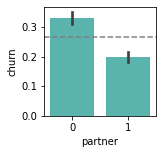


_____________________

dependents 
_____________________

        chi2       p-value  degrees of freedom
0  107.05414  4.331728e-25                   1

observed:
 churn          0     1   All
dependents                  
0           1898   866  2764
1            993   180  1173
All         2891  1046  3937

expected:
              0           1
0  2029.647955  734.352045
1   861.352045  311.647955


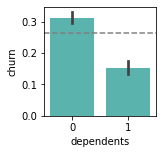


_____________________

phone_service 
_____________________

       chi2   p-value  degrees of freedom
0  0.019293  0.889529                   1

observed:
 churn             0     1   All
phone_service                  
0               284   105   389
1              2607   941  3548
All            2891  1046  3937

expected:
              0           1
0   285.648717  103.351283
1  2605.351283  942.648717


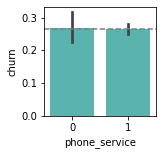


_____________________

multiple_lines 
_____________________

       chi2  p-value  degrees of freedom
0  5.568168  0.01829                   1

observed:
 churn              0     1   All
multiple_lines                  
0               1718   577  2295
1               1173   469  1642
All             2891  1046  3937

expected:
              0           1
0  1685.254001  609.745999
1  1205.745999  436.254001


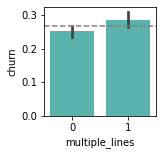


_____________________

online_security 
_____________________

         chi2       p-value  degrees of freedom
0  123.290758  1.204406e-28                   1

observed:
 churn               0     1   All
online_security                  
0                1930   888  2818
1                 961   158  1119
All              2891  1046  3937

expected:
              0           1
0  2069.300991  748.699009
1   821.699009  297.300991


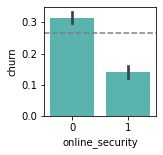


_____________________

device_protection 
_____________________

        chi2  p-value  degrees of freedom
0  18.146735  0.00002                   1

observed:
 churn                 0     1   All
device_protection                  
0                  1861   750  2611
1                  1030   296  1326
All                2891  1046  3937

expected:
              0           1
0  1917.297689  693.702311
1   973.702311  352.297689


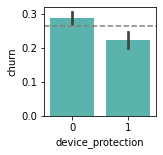


_____________________

tech_support 
_____________________

         chi2       p-value  degrees of freedom
0  111.685092  4.188204e-26                   1

observed:
 churn            0     1   All
tech_support                  
0             1919   876  2795
1              972   170  1142
All           2891  1046  3937

expected:
              0           1
0  2052.411735  742.588265
1   838.588265  303.411735


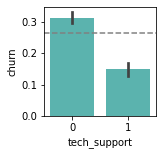


_____________________

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  13.235863  0.000275                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1847   601  2448
1             1044   445  1489
All           2891  1046  3937

expected:
              0           1
0  1797.604267  650.395733
1  1093.395733  395.604267


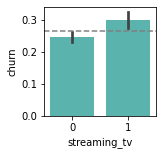


_____________________

streaming_movies 
_____________________

        chi2   p-value  degrees of freedom
0  12.040155  0.000521                   1

observed:
 churn                0     1   All
streaming_movies                  
0                 1836   600  2436
1                 1055   446  1501
All               2891  1046  3937

expected:
              0           1
0  1788.792482  647.207518
1  1102.207518  398.792482


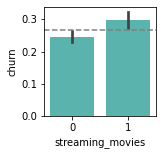


_____________________

paperless_billing 
_____________________

         chi2       p-value  degrees of freedom
0  141.804263  1.073200e-32                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1351   267  1618
1                  1540   779  2319
All                2891  1046  3937

expected:
              0           1
0  1188.122428  429.877572
1  1702.877572  616.122428


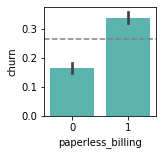


_____________________

gender_Male 
_____________________

       chi2  p-value  degrees of freedom
0  0.110206  0.73991                   1

observed:
 churn           0     1   All
gender_Male                  
0            1426   509  1935
1            1465   537  2002
All          2891  1046  3937

expected:
              0           1
0  1420.900432  514.099568
1  1470.099568  531.900432


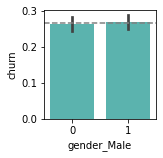


_____________________

payment_type_Credit card (automatic) 
_____________________

        chi2       p-value  degrees of freedom
0  76.550586  2.146438e-18                   1

observed:
 churn                                    0     1   All
payment_type_Credit card (automatic)                  
0                                     2179   924  3103
1                                      712   122   834
All                                   2891  1046  3937

expected:
              0           1
0  2278.580899  824.419101
1   612.419101  221.580899


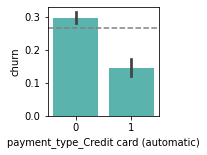


_____________________

payment_type_Electronic check 
_____________________

         chi2       p-value  degrees of freedom
0  335.348449  6.575305e-75                   1

observed:
 churn                             0     1   All
payment_type_Electronic check                  
0                              2168   458  2626
1                               723   588  1311
All                            2891  1046  3937

expected:
              0           1
0  1928.312421  697.687579
1   962.687579  348.312421


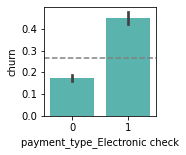


_____________________

payment_type_Mailed check 
_____________________

       chi2       p-value  degrees of freedom
0  39.69727  2.965397e-10                   1

observed:
 churn                         0     1   All
payment_type_Mailed check                  
0                          2154   880  3034
1                           737   166   903
All                        2891  1046  3937

expected:
              0           1
0  2227.913132  806.086868
1   663.086868  239.913132


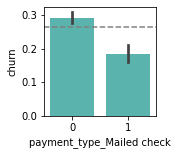


_____________________

internet_service_type_DSL 
_____________________

        chi2       p-value  degrees of freedom
0  53.978347  2.027113e-13                   1

observed:
 churn                         0     1   All
internet_service_type_DSL                  
0                          1789   780  2569
1                          1102   266  1368
All                        2891  1046  3937

expected:
              0           1
0  1886.456439  682.543561
1  1004.543561  363.456439


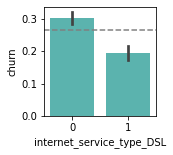


_____________________

internet_service_type_Fiber optic 
_____________________

         chi2       p-value  degrees of freedom
0  370.972197  1.149523e-82                   1

observed:
 churn                                 0     1   All
internet_service_type_Fiber optic                  
0                                  1909   330  2239
1                                   982   716  1698
All                                2891  1046  3937

expected:
              0           1
0  1644.132334  594.867666
1  1246.867666  451.132334


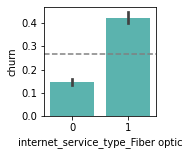


_____________________

internet_service_type_None 
_____________________

        chi2       p-value  degrees of freedom
0  210.52189  1.056829e-47                   1

observed:
 churn                          0     1   All
internet_service_type_None                  
0                           2084   982  3066
1                            807    64   871
All                         2891  1046  3937

expected:
              0           1
0  2251.411227  814.588773
1   639.588773  231.411227


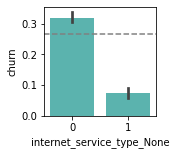


_____________________

contract_type_Month-to-month 
_____________________

         chi2        p-value  degrees of freedom
0  673.238576  1.973847e-148                   1

observed:
 churn                            0     1   All
contract_type_Month-to-month                  
0                             1682   120  1802
1                             1209   926  2135
All                           2891  1046  3937

expected:
              0           1
0  1323.236474  478.763526
1  1567.763526  567.236474


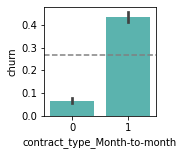


_____________________

contract_type_One year 
_____________________

         chi2       p-value  degrees of freedom
0  140.547923  2.020214e-32                   1

observed:
 churn                      0     1   All
contract_type_One year                  
0                       2147   960  3107
1                        744    86   830
All                     2891  1046  3937

expected:
              0           1
0  2281.518161  825.481839
1   609.481839  220.518161


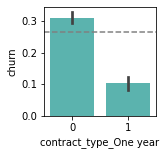


_____________________

monthly_charges 
____________________



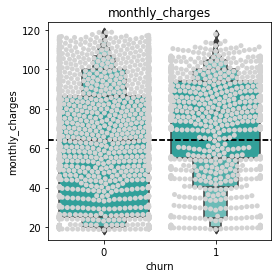

        count       mean        std    min   25%     50%   75%     max
churn                                                                 
0      2891.0  60.764182  31.116136  18.55  25.0  63.550  86.6  118.75
1      1046.0  73.662428  24.884594  18.85  55.2  79.075  94.0  117.80 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1151702.0, pvalue=2.727705309336549e-30)

____________________

tenure 
____________________



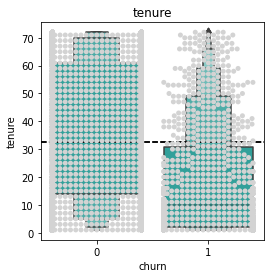

        count       mean        std  min   25%   50%    75%   max
churn                                                            
0      2891.0  37.583535  24.349023  1.0  14.0  37.0  61.00  72.0
1      1046.0  18.471319  20.088146  1.0   2.0  10.0  30.75  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2216535.5, pvalue=6.607556989659038e-111)

____________________

tenure_years 
____________________



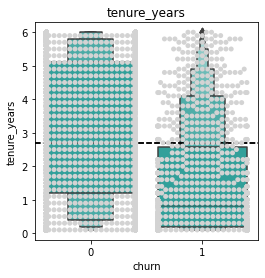

        count      mean       std  min  25%  50%    75%  max
churn                                                       
0      2891.0  3.132065  2.028675  0.1  1.2  3.1  5.100  6.0
1      1046.0  1.539962  1.671955  0.1  0.2  0.8  2.575  6.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2216692.0, pvalue=5.475398882250671e-111)

____________________

total_charges 
____________________



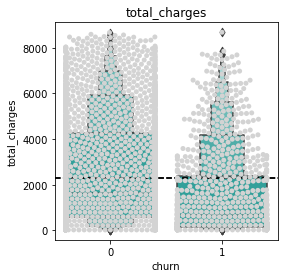

        count         mean          std    min      25%       50%       75%  \
churn                                                                         
0      2891.0  2547.079505  2348.789040  18.80  570.000  1651.950  4252.100   
1      1046.0  1547.428394  1927.458468  18.85  134.775   666.575  2362.025   

           max  
churn           
0      8672.45  
1      8684.80   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1957884.0, pvalue=1.754576942195511e-45)

____________________



In [17]:
e.explore_bivariate(train, target, cat_vars, quant_vars)

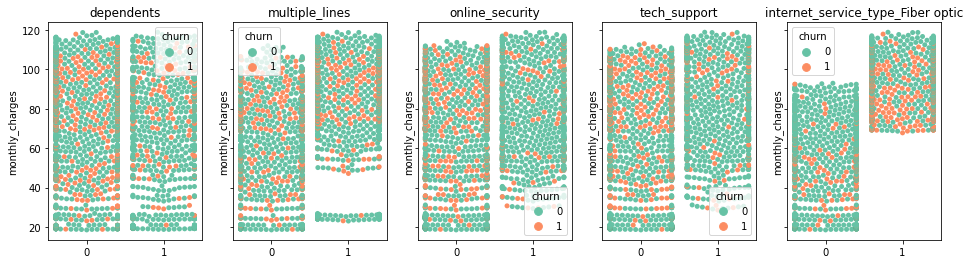

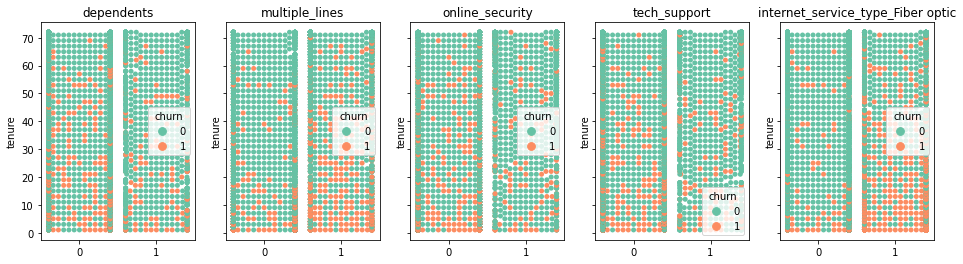

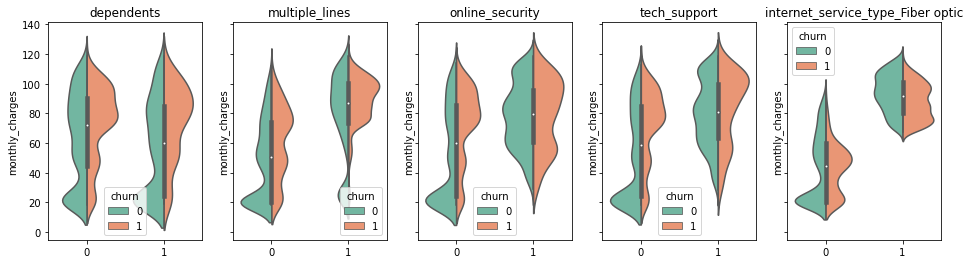

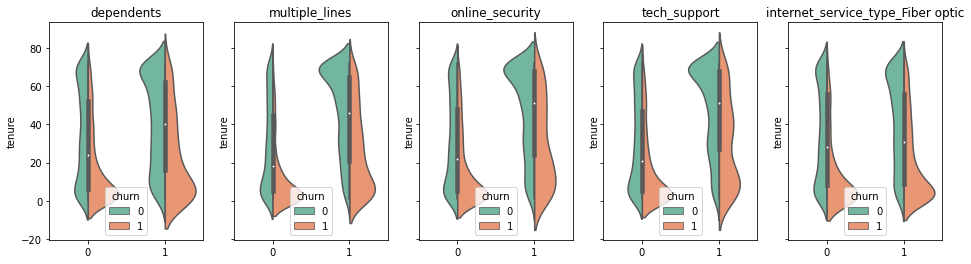

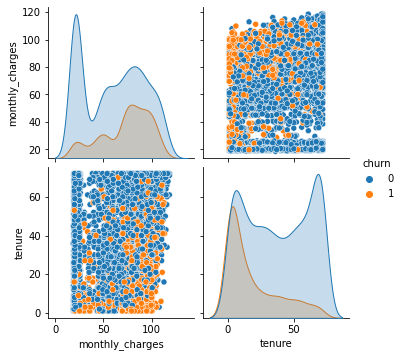

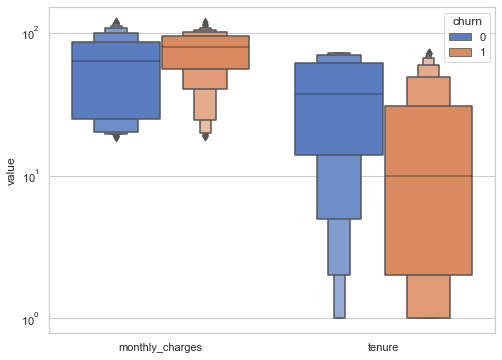

In [18]:
e.explore_multivariate(train, target, ['dependents','multiple_lines','online_security','tech_support','internet_service_type_Fiber optic'], ['monthly_charges','tenure'])

### Hypotheses Tests

**Hypothesis 1**

- $H_{0}$: churn and customer having tech support are independent
- $H_{a}$: churn and customer having tech support are dependent

We set $\alpha$ to 0.05

In [19]:
alpha = 0.05

tech_support 
_____________________

         chi2       p-value  degrees of freedom
0  111.685092  4.188204e-26                   1

observed:
 churn            0     1   All
tech_support                  
0             1919   876  2795
1              972   170  1142
All           2891  1046  3937

expected:
              0           1
0  2052.411735  742.588265
1   838.588265  303.411735


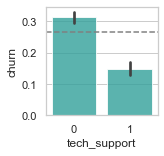


_____________________



In [20]:
e.explore_bivariate_categorical(train, target, 'tech_support')

In [21]:
observed = pd.crosstab(train['tech_support'], train['churn'])
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(111.68509175279506, 4.188203665104586e-26)

In [22]:
if  p < alpha:
    print(f'We reject the null hypothesis!')
    print(f'Churn and customer having tech support are dependent.')
else:
    print(f'We accept the null hypothesis!')
    print(f'Churn and customer having tech support are independent.')

We reject the null hypothesis!
Churn and customer having tech support are dependent.


**Hypothesis 2**

- $H_{0}$: Monthly charge is the same with fiber optic internet

- $H_{a}$: Monthly charge is not the same with fiber optic internet

We set $\alpha$ to 0.05

In [23]:
alpha = 0.05

monthly_charges 
____________________



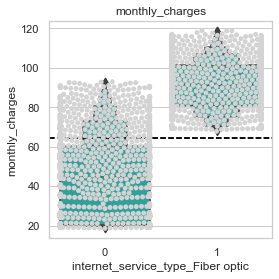

                                    count       mean        std    min  \
internet_service_type_Fiber optic                                        
0                                  2239.0  43.512841  21.900603  18.55   
1                                  1698.0  91.457538  12.841375  67.75   

                                       25%     50%      75%     max  
internet_service_type_Fiber optic                                    
0                                  20.4500  44.550   60.175   92.90  
1                                  80.4125  91.475  101.225  118.75   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=130775.0, pvalue=0.0)

____________________



In [24]:
e.explore_bivariate_quant(train, 'internet_service_type_Fiber optic', 'monthly_charges')

In [25]:
x = train[train['internet_service_type_Fiber optic'] == 1].monthly_charges
y = train[train['internet_service_type_Fiber optic'] == 0].monthly_charges

In [26]:
stat, p = stats.mannwhitneyu(x, y)
stat, p

(130775.0, 0.0)

In [27]:
if  p < alpha:
    print(f'We reject the null hypothesis!')
    print(f'Monthly charge is not the same with fiber optic internet.')
else:
    print(f'We accept the null hypothesis!')
    print(f'monthly charge is the same with fiber optic internet.')

We reject the null hypothesis!
Monthly charge is not the same with fiber optic internet.


**Hypothesis 3**

$H_{0}$: Mean of total charges of customers who are churned <= Mean total charges of all customers

$H_{a}$: Mean of total charges of customers who are churned > Mean total charges of all customers

We set $\alpha$ to 0.05

In [28]:
alpha = .05

<AxesSubplot:>

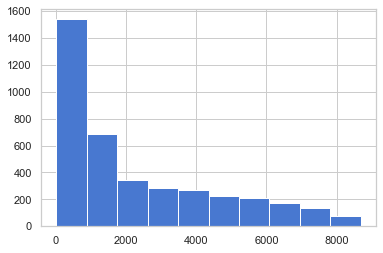

In [29]:
train['total_charges'].hist()

<AxesSubplot:>

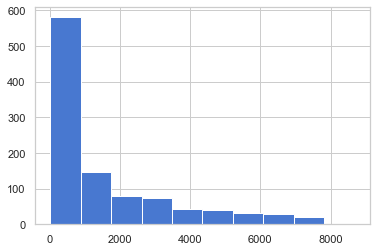

In [30]:
churn_sample = train[train.churn == 1].total_charges
churn_sample.hist()

In [31]:
alpha = .05

In [32]:
churn_sample = train[train.churn == 1].total_charges
churn_sample

6947      19.60
6791      20.00
3879     523.50
3474     272.20
4594    1046.10
         ...   
4674      79.35
3381    7491.75
1577      95.05
3993    4016.85
4200    1167.80
Name: total_charges, Length: 1046, dtype: float64

In [33]:
overall_mean = train.total_charges.mean()
overall_mean

2281.48766827534

In [34]:
t, p = stats.ttest_1samp(churn_sample, overall_mean)
t, p, p/2, alpha

(-12.317198587388003, 1.1922280712996771e-32, 5.961140356498386e-33, 0.05)

In [35]:
print('Is p-value significant?', p/2 < alpha)
print('Is t greater than 0?', t > 0)

Is p-value significant? True
Is t greater than 0? False


In [36]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")
print('The mean of total charges of customers who are churned <= Mean total charges of all customers')

We fail to reject $H_{0}$
The mean of total charges of customers who are churned <= Mean total charges of all customers


**Explore: Findings and Takeaways**
- Having tech support decreased chances of customer churn
- Having Fiber optic is a good indicator of customer churn
- When only compared to churn, customers who churned have total charges less than or equal to all customers' total charges

## Model & Evaluate

**MVP**
- I will be creating models using Random Forest, KNearestNeighbor, and Logistic Regression to find the best churn predictor
- I will create a baseline model to compare my other models.
- I will be creating a confusion matrix and classification report for each model
- I will compute accuracy on the X_train

In [37]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

### Baseline

The baseline will be used as a benchmark to compare how well our real models preform and if we would be better off using no model at all.

Since most customers have not churned (churn == 0), a baseline prediction of no churns will be created.

In [38]:
train.churn.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

In [39]:
# 1. Create the baseline
baseline = DummyClassifier(strategy='constant', constant=0) # baseline predicts no churns

# 2. Fit the baseline
baseline.fit(X_train, y_train)

#Baseline accuracy
print('Baseline accuracy of baseline classifier on training set: {:.2f}'
     .format(baseline.score(X_train, y_train)))
print('Baseline accuracy of baseline classifier on validate set: {:.2f}'
     .format(baseline.score(X_validate, y_validate)))

Baseline accuracy of baseline classifier on training set: 0.73
Baseline accuracy of baseline classifier on validate set: 0.73


In [40]:
# Estimate probability of churn value for each customer, using the new data.
y_pred_proba = baseline.predict_proba(X_train)

# Classify each feature by its estimated churn status.
y_pred = baseline.predict(X_train)

In [41]:
# columns: pred_died, pred_survived
#row1: actual_died
#row2: actual_survived

con_mat =  pd.DataFrame(confusion_matrix(y_train, y_pred))
con_mat

0  1
0  2891  0
1  1046  0

In [42]:
# True positive = Survived and marked as survived
tp = con_mat[1][1]
# True negative = Died and marked as died
tn = con_mat[0][0]
# False positive = Died but marked as survived
fp = con_mat[1][0]
# False negative = Survived but marked as died
fn = con_mat[0][1]

tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))

tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))

fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))

fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.0
 True negative rate = 1.0
False positive rate = 0.0
False negative rate = 1.0


In [43]:
class_mat = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
class_mat

0       1  accuracy    macro avg  weighted avg
precision     0.734315     0.0  0.734315     0.367158      0.539219
recall        1.000000     0.0  0.734315     0.500000      0.734315
f1-score      0.846807     0.0  0.734315     0.423404      0.621824
support    2891.000000  1046.0  0.734315  3937.000000   3937.000000

### Random Forest

In [44]:
# Create the model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=20,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=123)

In [45]:
# Fit the model using new train dfs
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=20, random_state=123)

In [46]:
# Classify each feature by its estimated churn status.
y_pred = rf.predict(X_train)

In [47]:
# Estimate probability of churn value for each customer, using the new data.
y_pred_proba = rf.predict_proba(X_train)

In [48]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on training set: 0.81
Accuracy of random forest classifier on validate set: 0.80


In [49]:
# columns: pred_died, pred_survived
#row1: actual_died
#row2: actual_survived

con_mat_rf =  pd.DataFrame(confusion_matrix(y_train, y_pred))
con_mat_rf

0    1
0  2686  205
1   542  504

In [50]:
# True positive = Survived and marked as survived
tp = con_mat_rf[1][1]
# True negative = Died and marked as died
tn = con_mat_rf[0][0]
# False positive = Died but marked as survived
fp = con_mat_rf[1][0]
# False negative = Survived but marked as died
fn = con_mat_rf[0][1]

tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))

tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))

fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))

fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.4818
 True negative rate = 0.9291
False positive rate = 0.0709
False negative rate = 0.5182


In [51]:
class_rep_rf = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
class_rep_rf

0            1  accuracy    macro avg  weighted avg
precision     0.832094     0.710860  0.810262     0.771477      0.799884
recall        0.929090     0.481836  0.810262     0.705463      0.810262
f1-score      0.877921     0.574359  0.810262     0.726140      0.797269
support    2891.000000  1046.000000  0.810262  3937.000000   3937.000000

In [52]:
# Extract single tree
estimator = rf.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(X_train.columns),
                class_names = 'churn',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### K-Nearest Neighbor

In [53]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=15, weights='uniform')

# Fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

In [54]:
# Classify each feature by its estimated churn status.
y_pred = knn.predict(X_train)

# Estimate probability of churn value for each customer, using the new data.
y_pred_proba = knn.predict_proba(X_train)

In [55]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on training set: 0.80
Accuracy of KNN classifier on validate set: 0.78


In [56]:
# columns: pred_died, pred_survived
#row1: actual_died
#row2: actual_survived

con_mat_knn =  pd.DataFrame(confusion_matrix(y_train, y_pred))
con_mat_knn

0    1
0  2703  188
1   606  440

In [57]:
# True positive = Survived and marked as survived
tp = con_mat_knn[1][1]
# True negative = Died and marked as died
tn = con_mat_knn[0][0]
# False positive = Died but marked as survived
fp = con_mat_knn[1][0]
# False negative = Survived but marked as died
fn = con_mat_knn[0][1]

tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))

tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))

fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))

fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.4207
 True negative rate = 0.935
False positive rate = 0.065
False negative rate = 0.5793


In [58]:
class_rep_knn = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
class_rep_knn

0            1  accuracy    macro avg  weighted avg
precision     0.816863     0.700637  0.798324     0.758750      0.785984
recall        0.934971     0.420650  0.798324     0.677810      0.798324
f1-score      0.871935     0.525687  0.798324     0.698811      0.779943
support    2891.000000  1046.000000  0.798324  3937.000000   3937.000000

### Logistic Regression

In [59]:
# Create the model
logit = LogisticRegression(C=1, random_state=250)


# Fit the model
logit.fit(X_train, y_train)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 3.39433580e-01  4.64147229e-02 -1.72088756e-01 -4.64795208e-02
  -8.38220355e-01  1.41716961e-01 -5.92153989e-01 -8.35036743e-02
  -5.09233026e-01  1.07426371e-01  1.16787396e-01  3.07091460e-01
   8.83325942e-03  1.65366839e-04  4.24144562e-02 -2.53376726e-01
   7.62569620e-02 -2.98669140e-01 -1.28480993e-01  4.86665114e-01
  -7.94502953e-01  6.34963621e-01 -2.70334776e-01 -1.63675932e-02]]
Intercept: 
 [-0.44316418]


In [60]:
# Make predictions
y_pred = logit.predict(X_train)

# Give probability of churn
y_pred_proba = logit.predict_proba(X_train)

In [61]:
# Evaluate the model

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))
print('----------')

Accuracy of Logistic Regression classifier on training set: 0.80
Accuracy of Logistic Regression classifier on validate set: 0.79
----------


In [62]:
# columns: pred_died, pred_survived
#row1: actual_died
#row2: actual_survived

con_mat_lr =  pd.DataFrame(confusion_matrix(y_train, y_pred))
con_mat_lr

0    1
0  2595  296
1   478  568

In [63]:
# True positive = Survived and marked as survived
tp = con_mat_lr[1][1]
# True negative = Died and marked as died
tn = con_mat_lr[0][0]
# False positive = Died but marked as survived
fp = con_mat_lr[1][0]
# False negative = Survived but marked as died
fn = con_mat_lr[0][1]

tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))

tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))

fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))

fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.543
 True negative rate = 0.8976
False positive rate = 0.1024
False negative rate = 0.457


In [64]:
class_rep_lr = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
class_rep_lr

0            1  accuracy    macro avg  weighted avg
precision     0.844452     0.657407  0.803404     0.750930      0.794757
recall        0.897613     0.543021  0.803404     0.720317      0.803404
f1-score      0.870221     0.594764  0.803404     0.732493      0.797037
support    2891.000000  1046.000000  0.803404  3937.000000   3937.000000

**Takeaways**
- Based on accuracy, Random Forest performed the best on the both train and validate datasets with 81% and 80%, respectively
- All models performed better that the baseline model's accuracy of 73%
- The model that had the best f1-score was Logistic Regression with ~59.5%
- Because of the higher f1-score, i will choose the Random Forest model to use on the test dataset

In [75]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.81


### The Ultimate Test

- Create a confusion matrix and classifiaction report with the test datasets
- Create preidctions and probailities of churn using test datasets
- Create a csv file using test datasets

In [66]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

In [67]:
# columns: pred_died, pred_survived
#row1: actual_died
#row2: actual_survived

con_mat_lr_test =  pd.DataFrame(confusion_matrix(y_test, y_pred))
con_mat_lr_test

0    1
0  921  112
1  158  216

In [68]:
# True positive = Survived and marked as survived
tp = con_mat_lr_test[1][1]
# True negative = Died and marked as died
tn = con_mat_lr_test[0][0]
# False positive = Died but marked as survived
fp = con_mat_lr_test[1][0]
# False negative = Survived but marked as died
fn = con_mat_lr_test[0][1]

tp_rate = tp / (tp+fn)
print(' True positive rate =',round(tp_rate, 4))

tn_rate = tn / (tn+fp)
print(' True negative rate =',round(tn_rate, 4))

fp_rate = fp / (tn+fp)
print('False positive rate =',round(fp_rate, 4))

fn_rate = fn / (tp+fn)
print('False negative rate =',round(fn_rate, 4))

 True positive rate = 0.5775
 True negative rate = 0.8916
False positive rate = 0.1084
False negative rate = 0.4225


In [69]:
class_rep_lr_test = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
class_rep_lr_test

0           1  accuracy    macro avg  weighted avg
precision     0.853568    0.658537  0.808102     0.756052      0.801726
recall        0.891578    0.577540  0.808102     0.734559      0.808102
f1-score      0.872159    0.615385  0.808102     0.743772      0.803905
support    1033.000000  374.000000  0.808102  1407.000000   1407.000000

In [70]:
test_pred_proba = pd.DataFrame(y_pred_proba, columns=logit.classes_.tolist())
test_pred_proba.tail()

0         1
1402  0.662372  0.337628
1403  0.252132  0.747868
1404  0.722841  0.277159
1405  0.978032  0.021968
1406  0.872242  0.127758

In [71]:
reset_test = test.reset_index()
reset_test.tail()

index  senior_citizen  partner  dependents  tenure  phone_service  \
1402   1524               0        0           0       1              1   
1403   3536               1        0           0       4              1   
1404   3927               1        1           0      66              1   
1405    263               0        0           0      63              1   
1406   3245               0        1           0      70              1   

      multiple_lines  online_security  device_protection  tech_support  ...  \
1402               0                0                  0             0  ...   
1403               0                0                  0             0  ...   
1404               1                0                  0             1  ...   
1405               1                1                  1             1  ...   
1406               1                0                  1             0  ...   

      gender_Male  payment_type_Credit card (automatic)  \
1402            1                                     0   
1403            1                                     0   
1404            1                                     1   
1405            0                                     1   
1406            1                                     0   

      payment_type_Electronic check  payment_type_Mailed check  \
1402                              0                          1   
1403                              1                          0   
1404                              0                          0   
1405                              0                          0   
1406                              0                          0   

      internet_service_type_DSL  internet_service_type_Fiber optic  \
1402                          1                                  0   
1403                          0                                  1   
1404                          0                                  1   
1405                          1                                  0   
1406                          0                                  1   

      internet_service_type_None  contract_type_Month-to-month  \
1402                           0                             1   
1403                           0                             1   
1404                           0                             1   
1405                           0                             0   
1406                           0                             0   

      contract_type_One year  tenure_years  
1402                       0           0.1  
1403                       0           0.3  
1404                       0           5.5  
1405                       0           5.2  
1406                       1           5.8  

[5 rows x 26 columns]

In [72]:
test_df = pd.concat([reset_test, test_pred_proba], axis=1)
test_df.tail()

index  senior_citizen  partner  dependents  tenure  phone_service  \
1402   1524               0        0           0       1              1   
1403   3536               1        0           0       4              1   
1404   3927               1        1           0      66              1   
1405    263               0        0           0      63              1   
1406   3245               0        1           0      70              1   

      multiple_lines  online_security  device_protection  tech_support  ...  \
1402               0                0                  0             0  ...   
1403               0                0                  0             0  ...   
1404               1                0                  0             1  ...   
1405               1                1                  1             1  ...   
1406               1                0                  1             0  ...   

      payment_type_Electronic check  payment_type_Mailed check  \
1402                              0                          1   
1403                              1                          0   
1404                              0                          0   
1405                              0                          0   
1406                              0                          0   

      internet_service_type_DSL  internet_service_type_Fiber optic  \
1402                          1                                  0   
1403                          0                                  1   
1404                          0                                  1   
1405                          1                                  0   
1406                          0                                  1   

      internet_service_type_None  contract_type_Month-to-month  \
1402                           0                             1   
1403                           0                             1   
1404                           0                             1   
1405                           0                             0   
1406                           0                             0   

      contract_type_One year  tenure_years         0         1  
1402                       0           0.1  0.662372  0.337628  
1403                       0           0.3  0.252132  0.747868  
1404                       0           5.5  0.722841  0.277159  
1405                       0           5.2  0.978032  0.021968  
1406                       1           5.8  0.872242  0.127758  

[5 rows x 28 columns]

In [73]:
test_df['prediction'] = y_pred
csv_df = test_df[['index','churn', 'prediction']]
csv_df.rename(columns={"index": "customer_id"}, inplace=True)
csv_df

customer_id  churn  prediction
0            2897      0           0
1            6407      0           0
2            6272      0           0
3            5638      0           0
4             903      0           0
...           ...    ...         ...
1402         1524      1           0
1403         3536      0           1
1404         3927      1           0
1405          263      0           0
1406         3245      0           0

[1407 rows x 3 columns]

In [74]:
# Create the csv file!!
csv_df.to_csv('predictions.csv')

**Key Takeaways and Findings**
- A big driver of customer churn is money
    - customers who perceive they are charged too much will leave
- big categorical drivers of churn are:
    - month-to-month contracts
    - having Fiber optic
    - not having tech support
- big quantitative driver of churn is:
    - monthly charges
- My best model was my Logistic Regression model because it had the best metric evaluation performance
    - returns 81% accuracy on test dataset

**Recommendations**
- Since month-to-month users have the highest churn rate of all, consider giving discounts to those with more services
- Consider making tech support standard for all customers

**Next Steps**
- tune hyperparameters of models
- pruning the columns more
- scaled the data, if necessary